In [57]:
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import os
import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings("ignore")

In [4]:
!wget https://raw.githubusercontent.com/shivanshka/Quora-Question-Similarity-Classification/master/data/train.csv

--2023-03-02 14:17:30--  https://raw.githubusercontent.com/shivanshka/Quora-Question-Similarity-Classification/master/data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62994819 (60M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  60.08M  94.9MB/s    in 0.6s    

2023-03-02 14:17:34 (94.9 MB/s) - ‘train.csv’ saved [62994819/62994819]



In [2]:
data = pd.read_csv("train.csv")

In [3]:
data.set_index('id')

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...
404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,537928,537929,What is one coin?,What's this coin?,0


In [4]:
data['is_duplicate'].value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

In [5]:
data.shape

(404290, 6)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


<Axes: xlabel='is_duplicate'>

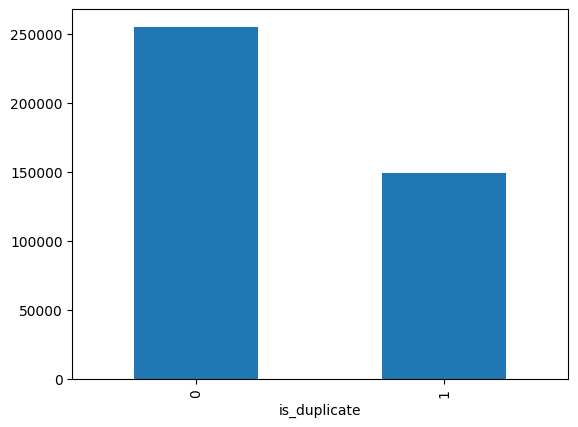

In [7]:
data.groupby('is_duplicate')['id'].count().plot.bar()

In [8]:
print("--> Total number of questions pairs for training: {}".format(len(data)))

--> Total number of questions pairs for training: 404290


In [11]:
print("--> No of similar questions pairs: {}%".format(100 - round(data['is_duplicate'].mean()*100,2)))
print("--> No of non-similar questions pairs: {}%".format(round(data['is_duplicate'].mean()*100,2)))

--> No of similar questions pairs: 63.08%
--> No of non-similar questions pairs: 36.92%


In [13]:
qids = pd.Series(data['qid1'].tolist() + data['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print('Total number of unique questions are: {}'.format(unique_qs))

print('Number of unique questions that appear more than one time: {} ({} %)'.format(qs_morethan_onetime, round((qs_morethan_onetime/unique_qs)*100,2)))
print('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))

q_vals = qids.value_counts()
q_vals = q_vals.values

Total number of unique questions are: 537933
Number of unique questions that appear more than one time: 111780 (20.78 %)
Max number of times a single question is repeated: 157



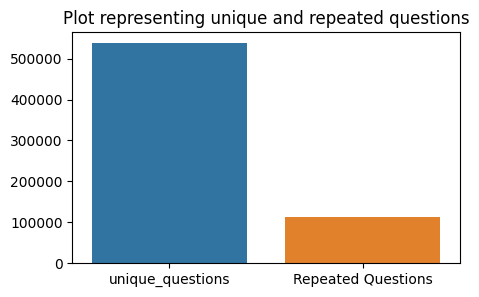

In [22]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(5, 3))
plt.title ("Plot representing unique and repeated questions")
sns.barplot(x=x,y=y)
plt.show()

#### Checking for Duplicates

In [26]:
pair_duplicates = data[['qid1','qid2', 'is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print("Number of duplicate questions pair: {}".format(pair_duplicates.shape[0] - data.shape[0]))

Number of duplicate questions pair: 0


#### Number of occurance of each question

Maximum number of times a single question is repeated: 157



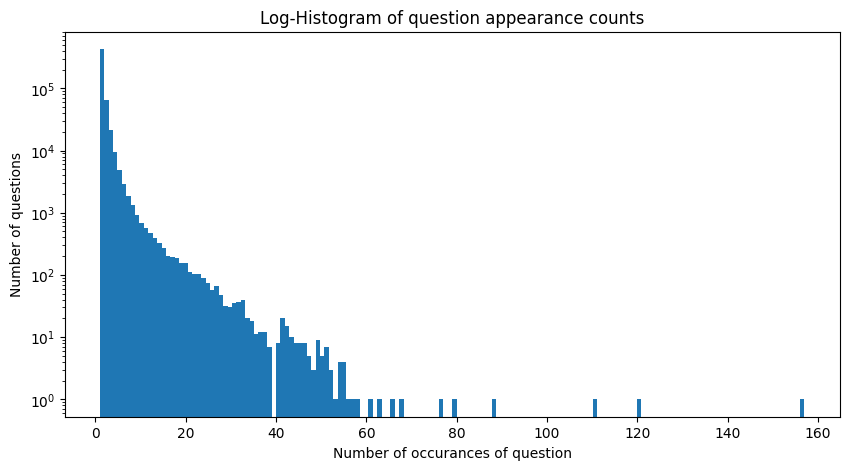

In [34]:
plt.figure(figsize=(10,5))
plt.hist(qids.value_counts(), bins=160)
plt.yscale('log')
plt.title("Log-Histogram of question appearance counts")
plt.xlabel("Number of occurances of question")
plt.ylabel("Number of questions")
print('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))

#### Checking for NULL values

In [41]:
nan_rows = data[data.isnull().any(1)]
print(nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


/tmp/ipykernel_2284/994595043.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  nan_rows = data[data.isnull().any(1)]


- There are three null values in total 1 in question1 and 2 in question2

In [42]:
## Replacing null values with ' '
data = data.fillna(' ')
nan_rows = data[data.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


/tmp/ipykernel_2284/1806623888.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  nan_rows = data[data.isnull().any(1)]


#### Feature Extraction before cleaning

In [46]:
data['freq_qid1'] = data.groupby('qid1')['qid1'].transform('count')
data['freq_qid2'] = data.groupby('qid2')['qid2'].transform('count')
data['q1len'] = data['question1'].str.len()
data['q2len'] = data['question2'].str.len()
data['q1_n_words'] = data['question1'].apply(lambda row: len(row.split(" ")))
data['q2_n_words'] = data['question2'].apply(lambda row: len(row.split(" ")))

def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * len(w1 & w2)
data['word_Common'] = data.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0*(len(w1) + len(w2))
data['word_Total'] = data.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
data['word_share'] = data.apply(normalized_word_share, axis=1)

data['freq_q1+q2'] = data['freq_qid1'] + data['freq_qid2']
data['freq_q1-q2'] = abs(data['freq_qid1'] - data['freq_qid2'])

data.to_csv("fe_without_preprocessing_train.csv",index=False)


data.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


#### Analysis of some of extracted features

In [50]:
print("Minimum length of the question in question 1 : ", min(data["q1_n_words"]))
print("Minimum length of the question in question 2 : ", min(data["q2_n_words"]))

print("Number of Questions with minimum length (question1) : ",len(data[data['q1_n_words']==min(data["q1_n_words"])]))
print("Number of Questions with minimum length (question2) : ",len(data[data['q2_n_words']==min(data["q2_n_words"])]))

Minimum length of the question in question 1 :  1
Minimum length of the question in question 2 :  1
Number of Questions with minimum length (question1) :  66
Number of Questions with minimum length (question2) :  22


In [70]:
 def feature_plot_analyse(data,feature_name): 
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.violinplot(x='is_duplicate', y = feature_name, data=data)
   
    plt.subplot(1,2,2)
    sns.distplot(data[data['is_duplicate']==1][feature_name], label='1', color='red')
    sns.distplot(data[data['is_duplicate']==0][feature_name], label='0', color='blue')

    plt.suptitle(feature_name)
    plt.show()

##### Feature : word_share

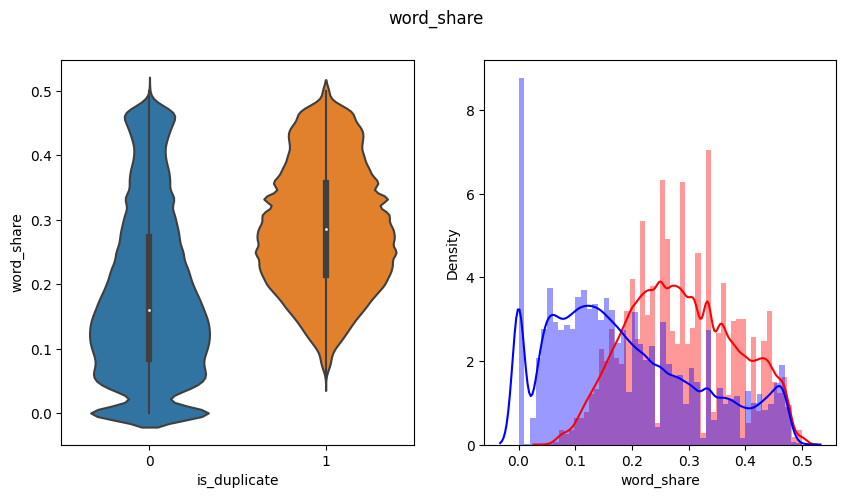

In [71]:
feature_plot_analyse(data, 'word_share')

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

#### Feature : word_Common

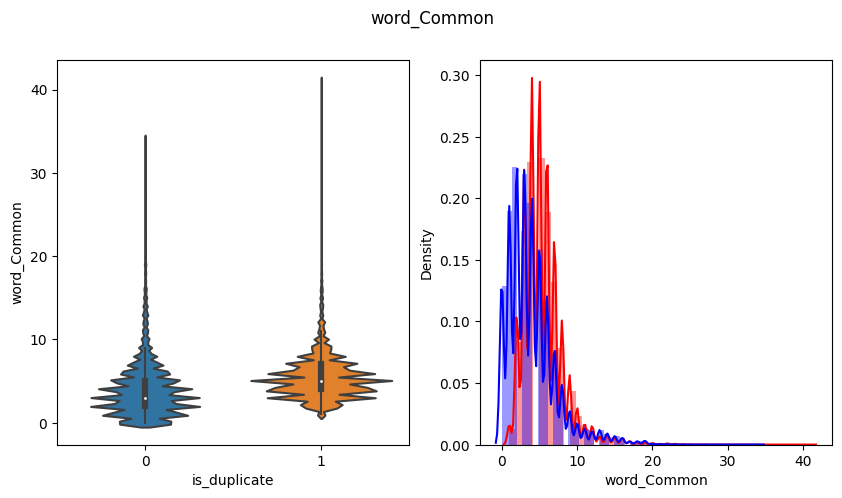

In [72]:
feature_plot_analyse(data, 'word_Common')

The distributions of the word_Common feature in similar and non-similar questions are highly overlapping. Therefore, this feature is not usefull for us